### Auto-Generated Code Cells

The following code cells contain code from external .py files that has been automatically added to remove these dependencies. This allows you to run this version of the SELENE notebook on Cloud platforms such as Google Colab. Run all following code cells before starting with the actual notebook content. 

Most Cloud platforms such as Google Colab have a wide range of Python packages preinstalled. However, if any import statements in the following code cells throws an error because of a missing package, you can create and run a new code cell to install the missing package using the `pip` command as shown here:
```
!pip install <package-name>
```

You can use the code cell below for convenience.

In [ ]:
#!pip install <package-name>

In [ ]:
# === Inline content for module src.utils.plotting.nn  ==

# === Inlined imports ===
import numpy as np
import matplotlib.pyplot as plt

# === Embedded configs ===


# === Inlined definitions ===
def plot_training_results(results, legend, normalize=True, fontsize=14):
    results = np.asarray(results)
    plt.figure()
    x = list(range(1, len(results) + 1))
    for idx in range(results.shape[1]):
        y = results[:, idx]
        if normalize == True and np.max(y) > 1:
            y = y / np.max(y)
        plt.plot(x, y, lw=3)
    plt.gca().set_xticks(x)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('Epoch', fontsize=fontsize)
    plt.legend(legend, loc='lower left', fontsize=fontsize)
    plt.tight_layout()
    plt.show()

In [ ]:
# === Inline content for module src.utils.data.files  ==

# === Inlined imports ===
import zipfile, tarfile
import bz2
from tqdm import tqdm
import requests
import os, re, yaml

# === Embedded configs ===
CONFIG = yaml.safe_load("""urls:
  downloads:
    notebooks: "https://github.com/chrisvdweth/selene/tree/master/notebooks"
    datasets: "https://chrisvdw.net/projects/selene/downloads/datasets/"
    models: "https://chrisvdw.net/projects/selene/downloads/models/"
    """)

# === Inlined definitions ===
def download_file(url, download_path, overwrite=False, ignore_html=False):
    file_name = url.split('/')[-1]
    create_folder(download_path)
    file_path = download_path + file_name
    if os.path.isfile(file_path) == True and overwrite is not True:
        print(f"File '{file_path}' already exists (use 'overwrite=True' to overwrite it).")
        return (file_path, download_path)
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(file_path, 'wb') as file:
        for data in response.iter_content(block_size):
            if ignore_html is True and is_html_file(data) is True:
                print('Error downloading file (expected data file, got HTML file)')
                return (None, None)
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print('Error downloading file (source does not exist)')
        return (None, None)
    return (file_path, download_path)

def create_folder(folder_name, exist_ok=True):
    try:
        os.makedirs(folder_name, exist_ok=exist_ok)
        return folder_name
    except:
        return None

def is_html_file(content):
    content = content.decode('utf-8', 'ignore').strip().lower()
    if content.startswith('<!doctype html') is True:
        return True
    elif content.startswith('<html') is True:
        return True
    return False

def decompress_file(file_name, target_path='.', overwrite=False):
    file_list = []
    if file_name.lower().endswith('zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_file:
            for member in zip_file.namelist():
                extracted_path = zip_file.extract(member, path=target_path)
                file_list.append(extracted_path)
        return file_list
    elif file_name.lower().endswith('tar.gz'):
        tar = tarfile.open(file_name, 'r:gz')
        tar.extractall(path=target_path)
        tar.close()
        return None
    elif file_name.lower().endswith('tar'):
        tar = tarfile.open(file_name, 'r:')
        tar.extractall(path=target_path)
        tar.close()
        return None
    elif file_name.lower().endswith('bz2'):
        output_file_name = target_path + file_name.split('/')[-1]
        output_file_name = re.sub('.bz2', '', output_file_name, flags=re.I)
        if os.path.isfile(output_file_name) == True and overwrite is not True:
            print('File "{}" already exists.'.format(output_file_name))
            return output_file_name
        with open(output_file_name, 'wb') as output_file, bz2.BZ2File(file_name, 'rb') as file:
            for data in iter(lambda: file.read(100 * 1024), b''):
                output_file.write(data)
        return output_file_name

def download_dataset(dataset_path, base_url=None, download_path=None, overwrite=False, ignore_html=True):
    if base_url is None:
        base_url = CONFIG['urls']['downloads']['datasets']
    if download_path is None:
        download_path = 'data/datasets/' + '/'.join(dataset_path.split('/')[0:-1]) + '/'
    url = base_url + dataset_path
    return download_file(url, download_path=download_path, overwrite=overwrite, ignore_html=ignore_html)

<img src="https://raw.githubusercontent.com/chrisvdweth/selene/refs/heads/master/notebooks/images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Implementing an ANN from Scratch (NumPy only)

This notebook walks through the implementation of a simple artificial neural network (ANN) for handwritten digit classification on the MNIST dataset, built **entirely from scratch using only NumPy**. The goal is deliberately *not* to achieve state-of-the-art accuracy or training efficiency. Instead, the focus is on exposing the core mechanics of neural networks by explicitly implementing every component that modern deep-learning frameworks usually abstract away.

The model architecture is intentionally minimal and consists of a sequence of **linear (fully connected) layers**, **ReLU activation functions**, and a **combined softmax + cross-entropy loss layer**. Each layer is implemented as an individual class with a clearly defined **forward pass** and **backward pass**, making the flow of data and gradients through the network explicit. By working directly with matrix operations and derivatives, this notebook highlights how backpropagation is realized in practice without relying on automatic differentiation.

A central theme of the notebook is understanding how gradients are computed and propagated efficiently. Rather than forming large Jacobian matrices, the backward passes are derived and implemented in a way that mirrors how real frameworks compute gradients under the hood. The combined softmax and cross-entropy layer, in particular, demonstrates how careful mathematical simplifications lead to both numerical stability and simpler gradient expressions—an approach used by libraries such as PyTorch and TensorFlow.

By the end of the notebook, you should have a clear mental model of what happens during training: how inputs are transformed layer by layer, how the loss quantifies prediction errors, how gradients flow backward through the network, and how parameters are updated via gradient descent. While real-world frameworks offer powerful features such as automatic differentiation, GPU acceleration, and highly optimized kernels, implementing an ANN in pure NumPy provides valuable insight into *why* these tools are designed the way they are, and just how much complexity they manage on your behalf.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split


#### Download MNIST Dataset

You can download the MNIST dataset as a '.zip' archive file by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
mnist_zip, mnist_folder = download_dataset("images/classification/mnist/mnist.zip")

print(f"mnist.zip downloaded into folder {mnist_folder}")

File 'data/datasets/images/classification/mnist/mnist.zip' already exists (use 'overwrite=True' to overwrite it).
mnist.zip downloaded into folder data/datasets/images/classification/mnist/


Running the code cell below extracts the `.zip` archive into the four dataset files &mdash; two for the training data and two for the test data. You can change the variable `mnist_folder` to change the folder into which the extracted files are placed; by default the files are placed into the same folder as the `.zip` file.

In [3]:
#mnist_folder = "/path/to/file/location/"

decompress_file(mnist_zip, target_path=mnist_folder)

['data/datasets/images/classification/mnist/t10k-images.idx3-ubyte',
 'data/datasets/images/classification/mnist/t10k-labels.idx1-ubyte',
 'data/datasets/images/classification/mnist/train-images.idx3-ubyte',
 'data/datasets/images/classification/mnist/train-labels.idx1-ubyte']

#### Preliminaries

* This notebook assumes a basic understanding of calculus and the chain rules, including the general concept of backpropagation for training neural networks.
* The implementations of the different layers briefly introduce the formulas of the underlying operations for the forward and backward pass, but skip the detailed math behind the computation of the gradients. These details are covered in full in separate notebooks discussing in more detail the different types of layers or loss functions.

---

## Load & Prepare Dataset

Before we can train a model for handwritten digit recognition, we first have to load the training and test data and convert it into a suitable representation to serve as input for the model. This includes loading the data from files into an internal representation in memory, and utilizing auxiliary classes provided by the PyTorch library to streamline the training and evaluation. In the following, we go through these two main steps in more detail.

### Load Images & Labels

The MNIST dataset is stored in a special binary file format called IDX, which has a specific header structure. For the image files (like `train-images.idx3-ubyte`), the first 16 bytes form the header that describes the metadata of the dataset. Here’s a breakdown of those first 16 bytes:

| Byte Offset | Length (bytes) | Description                                                |
|-------------|----------------|------------------------------------------------------------|
| 0           | 4              | **Magic number** (0x00000803) — identifies the file type as a set of images |
| 4           | 4              | **Number of images** (e.g., 60,000 for training set)       |
| 8           | 4              | **Number of rows** (28)                                    |
| 12          | 4              | **Number of columns** (28)          

In more detail:
* **Bytes 0-3:** Magic number = 0x00000803 (2051 in decimal, which means this is an image file)
* **Bytes 4-7:** Number of images (e.g., 60,000 or 10,000)
* **Bytes 8-11:** Number of rows per image (28)
* **Bytes 12-15:** Number of columns per image (28)

After these 16 bytes, the actual image pixel data starts &mdash; where each pixel is stored as an unsigned byte (0 to 255).

The method `load_mnist_images()` below reads an IDX image file of the MNIST dataset. The [`frombuffer()`](https://numpy.org/doc/stable/reference/generated/numpy.frombuffer.html) method of the NumPy library interprets a buffer (like a byte string or bytearray) as a 1-dimensional NumPy array without copying the data. It allows to quickly convert raw binary data into a NumPy array by specifying the desired data type (`dtype`). Since each pixel is stored as an unsigned byte (0 to 255), we can use `uint8` as the data type. Also notice the `offset=16` which conveniently allows to skip the first 16 bytes of the header

The `frombuffer()` method returns a long 1d array containing the pixel values for all images. The method `load_mnist_images()` therefore reshapes this 1d array into a 2d array where the rows (i.e., 1st dimension) reflects the number of images and the columns (i.e., 2nd dimension) reflects the number of pixels per image (i.e., 28$\times$28=784).

In [4]:
def load_mnist_images(path):
    with open(path, "rb") as f:
        # First 16 bytes are magic number, n_imgages, n_rows, n_columns
        pixels = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    # Reshape array into (n_images, n_pixels_per_image) and return
    return pixels.reshape(-1, 784)

With this method we can now load the images of the training and the test dataset. Note that this dataset is not very large, so there is no problem holding all images in memory.

In [5]:
X_train = load_mnist_images(mnist_folder+"train-images.idx3-ubyte")
X_test  = load_mnist_images(mnist_folder+"t10k-images.idx3-ubyte")

print(f"Shape (n_images, n_pixels) of training data: {X_train.shape}")
print(f"Shape (n_images, n_pixels) of test data: {X_test.shape}")

Shape (n_images, n_pixels) of training data: (60000, 784)
Shape (n_images, n_pixels) of test data: (10000, 784)


For the training and the valuation we also need the ground-truth labels which are stored in two separate files. For the label files in the MNIST dataset (like train-labels-idx1-ubyte), the first 8 bytes form the header that describes the dataset metadata. Here’s the breakdown of those first 8 bytes:

| Byte Offset | Length (bytes) | Description                                                |
|-------------|----------------|------------------------------------------------------------|
| 0           | 4              | **Magic number** (0x00000801) — identifies the file type as labels |
| 4           | 4              | **Number of labels** (e.g., 60,000 for training set)       |

In more detail:
* **Bytes 0-3:** Magic number = 0x00000801 (2049 in decimal — means this is a label file)
* **Bytes 4-7:** Number of labels (e.g., 60000 or 10000)

After these 8 bytes, the actual label data starts &mdash; each label is stored as a single unsigned byte (representing the digit 0–9). Again, let's define a simple method `load_mnist_labels()` to read the label files and store all labels as NumPy array.

In [6]:
def load_mnist_labels(path):
    with open(path, "rb") as f:
        # First 8 bytes are magic_number, n_images
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return labels

We can now call method `load_mnist_labels()` twice to load the labels of the training and the test dataset.

In [7]:
y_train = load_mnist_labels(mnist_folder+"train-labels.idx1-ubyte")
y_test  = load_mnist_labels(mnist_folder+"t10k-labels.idx1-ubyte")

print(f"Shape (n_images, ) of training labels: {y_train.shape}")
print(f"Shape (n_images, ) of test labels: {y_test.shape}")

Shape (n_images, ) of training labels: (60000,)
Shape (n_images, ) of test labels: (10000,)


Before we continue, let's have a quick look at some example images. The code cell below plots the first $k$ handwritten digits of the test dataset. For a better visualization the images are plotted in a grid with `n_row` rows and `n_cols` columns. Thus, for the default values `n_row, n_col = 3, 5`, the number of shown images is $k=15$. You can change the values of `n_row` and `n_cols` to see more or less example images.

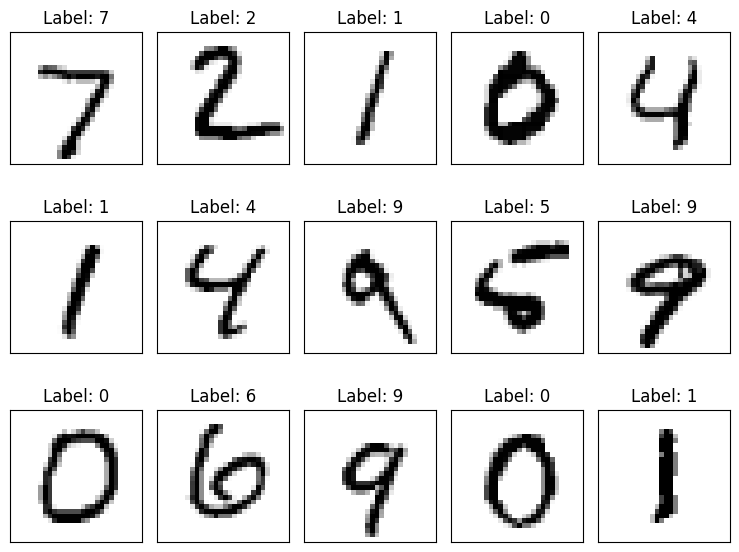

In [8]:
n_row, n_col = 3, 5

fig, axes = plt.subplots(n_row, n_col, figsize=(1.5*n_col,2*n_row))
for i in range(n_row*n_col):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(X_test[i].reshape(28,28), cmap='gray_r')
    ax.set_title('Label: {}'.format(y_test[i]))
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.show()

A very important observation is that the MNIST dataset (and similar datasets containing hand-written digits) contains **size-normalized** and **centered** digits in **fixed-size images** &mdash; more specifically:

* **Size-normalized:** Each handwritten digit has been scaled so that its shape roughly fits within a standard size, regardless of how large or small the original handwritten digit was. This means tall, narrow, short, or wide digits are all resized to be comparable in scale, which reduces variability caused by different handwriting styles.

* **Centered in fixed-size images:** Every digit is placed in the middle of a 28$\times$28 pixel image. The image size is fixed &mdash; that is, all images have exactly the same dimensions. The digit itself is centered within the image so that it does not touch the edges and is consistently located, making it easier for machine learning models to learn relevant patterns without worrying about positional shifts.

This preprocessing step helps ensure that the variation in the dataset comes mainly from handwriting style rather than inconsistencies in size or position, which simplifies the task for machine learning models and is eventually the reason why more sophisticated neural network architectures such as CNNs are not required to address this task of handwritten digit recognition.

Before we can use the dataset for training our model, we have one last step to do. Our model uses a basic implementation of the corss-entropy loss which expects, apart from the softmax probabilities, the ground truth as a one-hot vector for each training sample. However, right now, each label of a training sample is represented by an integer value reflecting the true class of that sample. This mean we need to convert the labels for the training data into one-hot vectors, e.g.:

$$\large
6 \rightarrow [0\ 0\ 0\ 0\ 0\ 0\ 1\ 0\ 0\ 0]
$$

where the class label $6$ is converted into a one-hot vector with a $1$ at index $6$. This conversion can easily be implemented in NumPy; see the auxiliary method `to_one_hot()` in the code cell below. This method expects a list or array of shape `(batch_size, )` and returns an array of shape `(batch_size, n_classes)` and each row in that array is a one-hot vector.

In [9]:
def to_one_hot(labels, n_classes):
    labels = np.asarray(labels)
    batch_size = labels.shape[0]

    one_hot = np.zeros((batch_size, n_classes), dtype=np.float32)
    one_hot[np.arange(batch_size), labels] = 1.0

    return one_hot

In practice, for a really large dataset, we could use this method during training to convert the labels for each batch on the fly. However, since the dataset and therefore the memory requirement is not very large, we can simply convert the labels for the whole training dataset in one go.

In [10]:
y_train_onehot = to_one_hot(y_train, 10)

Notice that we create a new array `y_train_onehot` instead of overwriting the original one. The reason is that we later want to use `y_train` and `y_train` to evaluate the model. We do this using built-in methods from the scikit-learn library, and these methods work directly with the class labels instead of one-hot vectors.

**Side note:** In practice, virtually all major deep-learning frameworks such as PyTorch and TensorFlow compute the cross-entropy loss directly from integer class labels rather than one-hot vectors, because this is both more **efficient and numerically stable**. Internally, these libraries fuse the softmax and cross-entropy operations into a single optimized kernel that only needs the index of the correct class, avoiding the explicit construction of large, mostly zero one-hot tensors and unnecessary multiplications. This reduces memory usage, improves performance, and allows the loss to be computed via simple indexed log-probabilities, while still yielding the same gradients as the one-hot formulation. However, this notebook focuses on clarity and the educational aspect.

---

## Model Implementation

In this notebook, we purposefully avoid using any deep-learning frameworks. Such provide highly-optimized implementation of core layers, activation functions, loss functions, and so on, which allow to build complex network architecture by "plugging together" these layer or function classes. This means that we have to implement each of these core components first before we can build the final model.

### Layers

The nature of the data (i.e., handwritten digits) means that may achieve good classification results even when just using a basic Artificial Neural Network (ANN) &mdash; compared to more challenging image classification tasks that basically call for more sophisticated architectures such as Convolutional Neural Networks (CNNs). The main advantage is that we only require very basic layers and functions, as ANNs for simple classification tasks often only require linear layers, activation functions (e.g., ReLU), softmax, and cross entropy to compute the loss. So these are the components we have to implement first.

#### Linear Layer

In simple terms, a **layer** in a neural network is a collection of neurons (or units) that perform the same operations over the same inputs &mdash; or different inputs but in a highly structured and shared way. In a linear layer, each neuron receives the same full input. Linear layers are therefore also called fully-connected layers or dense layers. The operation each neuron of a linear layer performs during the forward pass is to compute the weighted sum of the input features plus a bias. More concretely, for a single (i.e., unbatched) input vector $x_{i} \in \mathbb{R}^D$, the $k$-th neuron computes:

$$\large
y_{ik} = \mathbf{w}_k^\top \mathbf{x}_{i} + b_k
$$

where $\mathbf{x}_i = [x_{i1}, x_{i2}, \dots, x_{iD}]^\top$ is the input vector of size $D$, and $\mathbf{w}_k = [w_{1k}, w_{2k},\dots w_{Dk}]$ is the weight vector associated with that $k$-th neuron and $b_k$ is its bias. Each neuron therefore produces one scalar output that represents how strongly the input aligns with its learned weight vector, shifted by the bias.

In practice, we compute the forward pass for *all neurons* and with respect to *all inputs* in a batch in parallel. We can express this computation using the following matrix notations, each of the components we have already defined:

$$\large 
\mathbf{Y}\ = \mathbf{X}\mathbf{W} + \mathbf{b}
$$

Note that the matrix product $\mathbf{XW}$ produces an output of shape $N \times D$, i.e., one output vector per input sample (i.e., $N$ is the number of samples). Since the bias is defined per neuron and not per sample, it must be added to every row of this matrix. This is why **broadcasting** is needed. Broadcasting means that the bias vector $\mathbf{b}$ is conceptually replicated $N$ times, once for each sample in the batch, so that it can be added element-wise to $\mathbf{XW}$. In practice, no actual copying is required; instead, $\mathbf{b}$ is treated as if it had shape $N \times D$, allowing the addition to be carried out efficiently.

As part of the backward pass through the linear layer, our goals is now to compute the gradients $\frac{\partial \mathcal{L}}{\partial \mathbf{X}}$ (i.e., the **downstream gradient** passed to the previous layer according to the forward pass), as well as the gradients $\frac{\partial \mathcal{L}}{\partial \mathbf{W}}$ and $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$ to update all weights and biases based on the optimization method (e.g., gradient descent). Skipping the math here, the solutions are in fact very simple and arguably intuitive given the basic rules of backpropagation:

$$
\large
\frac{\partial \mathcal{L}}{\partial \mathbf{X}} = \frac{\partial \mathcal{L}}{\partial \mathbf{Y}}\mathbf{W}^\top\ , \qquad \frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \mathbf{X}^\top \frac{\partial\mathcal{L}}{\partial\mathbf{Y}}\ , \qquad \frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \begin{bmatrix}
1 & 1 & \dots & 1
\end{bmatrix}
\frac{\partial\mathcal{L}}{\partial\mathbf{Y}}
$$

Note that, in practice, we typically do not compute the gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$ as a product of these two matrices. Since this product yields the same result as simply adding all rows of the upstream gradient $\frac{\partial\mathcal{L}}{\partial\mathbf{Y}}$, the row-wise summation is typically easier and more efficient to implement.

Computing all required gradients during the backward pass through a linear layer comes down to basic matrix operations (i.e., multiplication and sums) that are all very well supported by NumPy. The class `Linear` in the code cell below represents a direct implementation of the formulas of the forward and the backward pass. Crucially, the class must also store all intermediate data required for the backward pass, such as the input $\matrix{X}$ from the forward computation. During training, gradients flow backward through the network, and computing the gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{W}}$ depends directly on values seen in the forward pass. This design not only improves computational efficiency but also makes the implementation closely align with the principles of backpropagation used in modern deep learning frameworks.

In [11]:
class Linear:
    
    def __init__(self, in_features, out_features):
        # Weight initialization (simple Gaussian)
        self.W = np.random.randn(in_features, out_features) * np.sqrt(2 / in_features)
        self.b = np.zeros(out_features)

        # Gradients
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        # Cache for backward pass
        self.X = None

    def forward(self, X):
        self.X = X
        return X @ self.W + self.b

    def backward(self, dY):        
        self.dW = self.X.T @ dY  # Gradient w.r.t. weights
        self.db = dY.sum(axis=0) # Gradient w.r.t. bias
        dX = dY @ self.W.T       # Gradient w.r.t. input
        return dX
    
    def step(self, lr):
        # Perform one gradient descent update
        self.W -= lr * self.dW
        self.b -= lr * self.db

Note that in NumPy, the `@` operator is syntactic sugar for matrix multiplication, introduced to clearly distinguish linear algebra operations from element-wise multiplication (`*`). When applied to arrays, `A @ B` follows standard linear algebra rules: for 2-D arrays it performs matrix–matrix multiplication, for 1-D arrays it computes inner products or matrix–vector products depending on the operands, and for higher-dimensional arrays it applies batched matrix multiplication over the leading dimensions using broadcasting. Under the hood, `@` is equivalent to calling `np.matmul(A, B)`, ensuring shape-aware multiplication that aligns with mathematical notation used in neural networks and other numerical computing tasks.

Apart from the `forward()` and `backward()` method, the class also features a `step()`. After computing the gradients using the `backward()` method, the `step()` updates the weight matrix $\mathbf{W}$ and the bias vector $\mathbf{b}$ using basic gradient descent &mdash; scaling down the gradients using a learning rate `lr` und substracting th scaled gradients from the current weights and biases. In most modern frameworks, these weight updates are handled separately to allow for the use of different optimizers beyond basic gradient descent. However, our goal here is to keep things simple and focus on the core concepts.

#### ReLU (Rectified Linear Unit)

The ReLU (Rectified Linear Unit) is one of the most popular activation functions used in deep learning. Its primary job is to decide whether a neuron should "fire" by introducing non-linearity into a neural network, which allows the model to learn complex patterns in data. Mathematically, it is a simple piecewise function that can be expressed as:

$$\large
\text{ReLU}(x) = \max(0, x).
$$

where $x$ is a single value in an input vector $\mathbf{x}$ or an input matrix $\mathbf{X}$.

In plain English, if the input $x$ is positive, the function returns $x$ directly; if the input is negative or zero, it returns $0$. From a learning perspective, ReLU introduces **non-linearity** while largely avoiding the vanishing gradient problem that affects activations like sigmoid or tanh. For positive inputs, its derivative is 1, allowing gradients to flow effectively during backpropagation. However, ReLU has a known drawback called the *"dying ReLU"* problem: if a neuron consistently receives negative inputs, its output and gradient become zero, and it may stop learning altogether.

On the plus side, the simplicity of the ReLU function also means that computing the gradient is very simple. Again, die gradient is piecewise defined as:

$$\large
\frac{d\ \text{ReLU}(x)}{dx} =
\begin{cases}
0, & x < 0 \\
1, & x > 0
\end{cases}
$$

In short, for any positive $x$, the gradient is $1$, and for any negative $x$ it is $0$. At $x = 0$, the derivative is strictly speaking not defined because the function has a kink. In practice, when implementing backpropagation, this point is handled by convention: most frameworks simply set the gradient to $0$ (sometimes $1$), but since the probability of a neuron being *exactly* at zero is negligible, this choice has no practical impact on training. Intuitively, this means gradients flow unchanged through ReLU for positive activations, while neurons with negative pre-activations block the gradient entirely.

These simple operations make the ReLU activation also very easy to implement; see the `ReLU` class in the code cell below. The expression `(self.X > 0)` in the `backward()` method creates a boolean mask that is `True` where the input was positive and `False` where it was non-positive. In NumPy, this mask is implicitly converted to `1` (for `True`) and `0` (for `False`) during multiplication. As a result, the gradient is passed through unchanged for elements where `X > 0` and zeroed out everywhere else. This is exactly how the piecewise gradient of ReLU is applied efficiently without explicitly writing conditional statements.

In [12]:
class ReLU:
    def __init__(self):
        # Cache for backward pass
        self.X = None

    def forward(self, X):
        self.X = X
        return np.maximum(0, X)

    def backward(self, dY):
        # Gradient flows only where X > 0
        dX = dY * (self.X > 0)
        return dX
        
    def step(self, lr):
        # Dummy method for consistent interface
        pass 

Notice that the `ReLU` class also has a `step()` method which is, however, empty. This is because ReLU has itself no trainable parameters that need to be updated during training. So whole the `step()` method is not needed here (like for the linear layer), ensuring that all layers have the same interface (i.e., the same set of methods) alter avoids checking whether a layer has trainable parameters or not &mdash; we can simple call `step()` for all the layers.

#### Softmax + Cross-Entropy

In classification tasks, **softmax** is typically used as the activation function of the final layer to convert raw model outputs (logits) into a **probability distribution** over classes. It exponentiates and normalizes the logits so that all outputs are non-negative and sum to one, making them interpretable as class probabilities. **Cross-entropy loss** then measures how well these predicted probabilities match the true class labels. It penalizes the model heavily when it assigns low probability to the correct class and only mildly when the correct class is already likely. Although softmax and cross-entropy can be considered as individual operations layers, when combined, the gradient of the loss simplifies significantly, leading to efficient and numerically stable training. 

Considering the softmax function as a layer in the network, the softmax function is defined as function $\sigma: \mathbb{R}^{D}\rightarrow \mathbb{R}^{D}$ that maps a real-valued vector of size $D$ into another real-valued vector of size $D$. If we denote vector $\mathbf{x}\in \mathbb{R}^D$ as the input vector, the $i$-th element of the output vector $\boldsymbol{\sigma}(\mathbf{x})$ is defined as:

$$\large
\sigma_i = \boldsymbol{\sigma}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{k=1}^D e^{x_k} }
$$

In simple terms, the softmax function takes in a vector with arbitrary values and normalizes them so that each values gets mapped into the interval $[0, 1]$ which allows for interpreting $\boldsymbol{\sigma}(\mathbf{x})$ as a probability distribution. The cross-entropy loss $\mathcal{L}$ for a given $D$-dimensional vector $\mathbf{y}$ containing the ground-truth labels is defined as:

$$\large
\mathcal{L}_{CE} = - \sum_{i=1}^D y_{i} \log{\sigma_i}
$$

where $y_{i}$ is either $0$ or $1$ depending if the $i$-th class is the true class ($1$) or the wrong class ($0$). The cross-entropy loss is only applicable to multiclass classification tasks where only one class is correct. This naturally implies that $\mathbf{y}$ is a one-hot vector containing only a single $1$ at the position reflecting the correct class label. Note that $D$ here reflects the number of classes, which must match the size of the output of the last linear layer before the softmax.

Although both softmax and cross-entropy have no trainable parameter themselves, we still need to compute the **downstream gradient** $\frac{\partial\mathcal{L}}{\mathbf{\partial x}}$ to be passed to the last linear layer. As mentioned before, combining softmax and cross-entropy yields are very elegant solution for the gradient &mdash; again, we skip all the math underpinning this solution here:

$$\large 
\frac{\partial\mathcal{L}}{\mathbf{\partial x}} = \boldsymbol{\sigma} - \mathbf{y}
$$

While this gradient is with respect to a single data sample, the extension to batched inputs containing multiple samples is straightforward.

The class `SoftmaxCrossEntropy` below represents a basic implementation of the cross-entropy loss together with a preceding softmax operation. The `forward()` and the `backward()` method directly implement all the formulas shown above using only built-in methods of NumPy. However, this implementation adds two practical extensions:

* **Stability trick:** The stability trick in the softmax computation consists of subtracting the maximum input value from all logits before applying the exponential, which does not change the final output probabilities but greatly improves numerical stability. Since the exponential function grows very rapidly, large positive logits can cause overflow, while very negative logits can lead to underflow and loss of precision. By shifting the logits so that the largest value becomes $0$, all exponentials are guaranteed to be at most $1$, keeping the computation in a safe numerical range. This works because softmax is invariant to adding or subtracting the same constant from all inputs, making the trick a simple yet essential step for reliable and stable training.


* **Loss and gradient averaging:** Dividing the loss and gradients by the batch size ensures that their scale is independent of how many samples are processed at once, making training behavior consistent across different batch sizes. When the loss is defined as the *mean* over the batch rather than the sum, each sample contributes equally regardless of batch size, and the magnitude of the gradients remains stable as the batch size changes. This helps keep learning rates meaningful and comparable: doubling the batch size does not automatically double the gradient magnitudes or require returning the optimizer. In practice, averaging over the batch leads to more predictable optimization dynamics and simplifies both theoretical reasoning and practical implementation of gradient-based learning.

In [13]:
class SoftmaxCrossEntropy:
    def __init__(self):
        self.probs = None
        self.labels = None

    def forward(self, logits, labels):
        # logits: (batch_size, num_classes) - Raw scores from the previous layer
        # labels: (batch_size, num_classes) - One-hot encoded ground truth
        self.labels = labels
        
        # Numerical stability trick: subtract max logit from all logits
        # This prevents e^x from exploding to infinity.
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        
        # Avoid log(0) by adding a tiny epsilon
        epsilon = 1e-12
        batch_size = logits.shape[0]
        
        # Compute Cross-Entropy loss
        loss = -np.sum(labels * np.log(self.probs + epsilon)) / batch_size
        return loss

    def backward(self):
        #Returns gradient: (batch_size, num_classes)
        batch_size = self.labels.shape[0]

        # The simplified gradient: (p - y) / batch_size
        grad = (self.probs - self.labels) / batch_size
        return grad

An instance of class `SoftmaxCrossEntropy` will naturally be the last layer of our final model architecture. It is therefore the only layer which will not receive any upstream gradient. Since we therefore have to treat his layer separately (see below) and it does not feature trainable parameters, this class does not need an empty `step()` method; although adding one would not cause any harm.

### Complete Model

With implementations for all required components in place, we can now implement our actual classification model. By default &mdash; but feel free to change it &mdash; the class `DigitsClassifier` implements a basic ANN with two hidden layers with $128$ neurons each and a ReLU activation function between both hidden layers. Note that the sequence of linear layers and activation functions are defined as a list `self.layers`. This allows in the `forward()`, `backward()`, and `step()` method to iterate through all layers and call the `forward()`, `backward()`, and `step()` method of each layer &mdash; of course, for the backward pass, we iterate through `self.layers` back to front. This makes the overall code not just sleek, it is also very easy to add or remove layers without changing the other methods.

In [14]:
class DigitsClassifier:

    def __init__(self, in_features):
        self.layers = [
            Linear(in_features, 128),
            ReLU(),
            #Linear(128, 128),  # Comment out these line
            #ReLU(),            # to add another layer
            Linear(128, 10)
        ]
        # Define loss function
        self.criterion = SoftmaxCrossEntropy()

    def forward(self, X, y):
        # Perform forward pass through all layers
        for layer in self.layers:
            X = layer.forward(X)

        # Compute and return loss (softmax + cross-entropy)
        return self.criterion.forward(X, y)

    def backward(self):
        dY = self.criterion.backward()
        for layer in reversed(self.layers):
            dY = layer.backward(dY)

    def step(self, lr):
        for layer in reversed(self.layers):
            layer.step(lr)

    def predict(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        # After the last layer, X contains the logits
        # Return the largest logit for each sample as the predicted class
        return np.argmax(X, axis=1)

After training the model, we also want to use it to make predictions, at least as part of the evaluation. Thus, the class also features the method `predict()`, which takes in a batch of images and returns the predicted class label $0, 1, \dots, 9$ for each image.

We can now create an instance of our model; note that passing `28*28` instead of `784` is not important, but it is a convenient reminder that ware actually dealing with $28\times 28$ pixel images here, although they are flattened to $784$-dimensional vectors.

In [15]:
model = DigitsClassifier(28*28)

## Model Training

We now have the data and the model train to start the training. To keep training code clean and easy to read, we first define a few auxiliary methods which we will then use in the actual training loop. Again, while frameworks such PyTorch or Tensorflow help with these steps, our goal is a NumPy-only implementation.

### Auxiliary Methods

Despite having $60k$ images in the training data, we could use the full dataset as a single batch for each training epoch. However, just to show a basic example how it can be done &mdash; although not in a very optimized way &mdash; we actually split the training data into multiple batches using the method `create_batches` below. If specified by the `shuffle` argument, the method first shuffles the data before creating the batches. Training data is often shuffled after each epoch to prevent the model from learning spurious patterns caused by the order of the data, such as correlations between consecutive samples. Shuffling ensures that each mini-batch is a different mix of examples across epochs, which leads to more representative gradient estimates, reduces bias during optimization, and generally improves convergence and generalization.

For improved efficiency, instead of return a list of all batches at once, we the `yield` keyword to turn the methods into a **generator function**. Instead of returning a value once and terminating (as `return` does), `yield` produces a value and temporarily pauses the function's execution, saving its internal state. When the generator is iterated again, execution resumes exactly where it left off. This allows values to be generated **lazily**, one at a time, rather than all at once. This will later allow us to iterate through the batches one by one (see the `train_epoch()` method next).

In [16]:
def create_batches(X, y, batch_size, shuffle=False):
    # Shuffle dataset for batching
    if shuffle is True:
        idx = np.random.permutation(len(X))
        X, y = X[idx], y[idx]
    # Create iterator that loops over bitaches
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        yield X[start:end], y[start:end]

For training the model, the code cell below defines the auxiliary method `train_epoch()` that implements that basic training loop for a single epoch &mdash; the training of a model with respect to all training samples using mini-batches. This method uses `create_batches()` to create and iterate through all the batches. Each batch is passed to the `forward()` method to compute the batch loss and the `backward()` method to compute all gradients, after which calling `step()` updates all model weights. During each iteration we accumulate the loss for each batch and return the overall loss for the epoch at the end.

In [17]:
def train_epoch(model, X, y, lr=0.001, batch_size=128, shuffle=True):
    epoch_loss = 0.0
    for X_batch, y_batch in create_batches(X, y, batch_size=batch_size, shuffle=shuffle):
        loss = model.forward(X_batch, y_batch)
        model.backward()
        model.step(lr)
        epoch_loss += loss
    return epoch_loss

Although not required for the training itself, we want to monitor how the prediction performance of our model changes over time, i.e., after each epoch. To this end, the model below implements the auxiliary method `evaluate()` that iterates over all training samples (again, in batches), calculates the predicted labels using the given model, and returns the F1 score based on the predicted and ground-truth labels.

In [18]:
def evaluate(model, X, y, batch_size = 128):
    # Define 2 lists holding all true labels and all predicted labels
    y_true, y_pred = [], []
    for X_batch, y_batch in create_batches(X, y, batch_size=batch_size, shuffle=False):
        y_batch_pred = model.predict(X_batch)
        y_true += list(y_batch)
        y_pred += list(y_batch_pred)
    # Return the final macro F1 score
    return metrics.f1_score(y_true, y_pred, average='macro')

Let's evaluate our currently untrained model on the test data by calling method `evaluate()` and the data loader holding the test data.

In [19]:
f1 = evaluate(model, X_test, y_test)

print(f"F1 score: {f1:.3f}")

F1 score: 0.043


While the exact result will different depending on the random initialization of the model parameters, the f1 score of the untrained model should roughly be around $0.1$. This is because our untrained model is more less just guessing, and given that we have 10 possible classes (0, 1, 2, ..., 9), the model will be correct about 10% of the time.

### Training Loop

Using the our two auxiliary methods `train_epoch()` and `evaluate()` training the model for several epochs (here: 20) &mdash; and evaluating the model after each epoch &mdash; becomes very simple, as shown in the code cell below. Notice that we call the `evaluate()` method twice, once for the training data and once for the test data to compute the training loss and test loss, respectively. Comparing both losses generally provide good insights if a model might be underfitting or overfitting.

For each epoch (i.e., in each iteration) we store the loss as well as the training and test f1 scores as a triple in the list `results` for later plotting; but the values are also directly printed after each epoch. So, simply run the code cell below to train the digits classifier model for 20 (by default) epochs. Keep in mind that you can also always go back and change the model architecture (e.g., by adding more linear layers or changing their sizes), the learning rate, or the number of epochs.

In [20]:
n_epochs = 20
results = []

for epoch in range(n_epochs):
    epoch_loss = train_epoch(model, X_train, y_train_onehot)
    # Calculate training and test f1 scores
    f1_train = evaluate(model, X_train, y_train)
    f1_test = evaluate(model, X_test, y_test)
    # Append the epoch loss, training f1 score, and test f1 score to final result list (for plotting later)
    results.append((epoch_loss, f1_train, f1_test))
    # Print progress(epoch loss, training f1 score, and test f1 score)
    print(f"[Epoch {epoch:02d}] loss: {epoch_loss:.3f}, f1 train: {f1_train:.3f}, f1 test: {f1_test:.3f}")      

[Epoch 00] loss: 961.682, f1 train: 0.822, f1 test: 0.816
[Epoch 01] loss: 329.456, f1 train: 0.860, f1 test: 0.852
[Epoch 02] loss: 246.243, f1 train: 0.884, f1 test: 0.877
[Epoch 03] loss: 203.907, f1 train: 0.896, f1 test: 0.884
[Epoch 04] loss: 177.255, f1 train: 0.908, f1 test: 0.893
[Epoch 05] loss: 157.515, f1 train: 0.915, f1 test: 0.901
[Epoch 06] loss: 143.215, f1 train: 0.921, f1 test: 0.907
[Epoch 07] loss: 132.249, f1 train: 0.925, f1 test: 0.911
[Epoch 08] loss: 122.547, f1 train: 0.930, f1 test: 0.914
[Epoch 09] loss: 115.337, f1 train: 0.931, f1 test: 0.915
[Epoch 10] loss: 109.280, f1 train: 0.937, f1 test: 0.916
[Epoch 11] loss: 103.646, f1 train: 0.939, f1 test: 0.921
[Epoch 12] loss: 99.089, f1 train: 0.940, f1 test: 0.923
[Epoch 13] loss: 94.838, f1 train: 0.941, f1 test: 0.920
[Epoch 14] loss: 91.018, f1 train: 0.944, f1 test: 0.925
[Epoch 15] loss: 88.067, f1 train: 0.946, f1 test: 0.925
[Epoch 16] loss: 85.155, f1 train: 0.948, f1 test: 0.929
[Epoch 17] loss: 82

Even when starting from an untrained model, you should see that the model already achieves an F1 score of over $0.8$ after the first epoch, and then only improves slightly more over time. This is because the task is a relatively easy one even for a simple ANN, as we will discuss more at the end. Since we keep track of the loss as well as the F1 scores regarding the training and the test data, we can also plot the results using the auxiliary method `plot_training_results()` we provide.

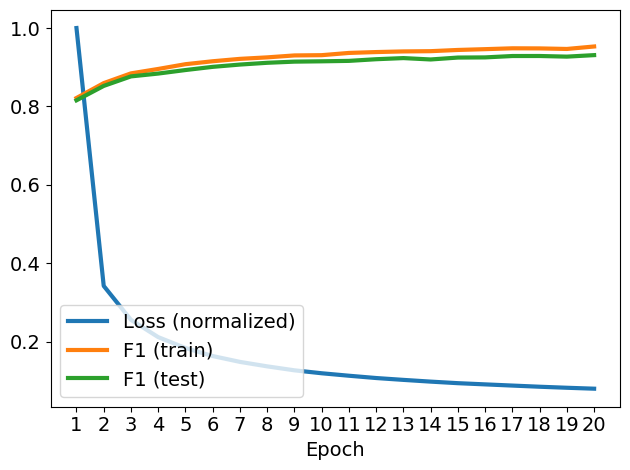

In [21]:
plot_training_results(results, legend=['Loss (normalized)', 'F1 (train)', 'F1 (test)'])

---

## Discussion

Implementing a neural network from scratch using only NumPy without any deep-learning framework or library is very educational in terms of understanding core concepts such as backpropagation and, in general, how deep-learning frameworks work. Of course, in practice, particularly when it comes to more complex models and much larger datasets, you want to use established frameworks such as PyTorch, Tensorflow, or others. Their implementations of all components (e.g., layers, activation functions, loss functions) are highly optimized and unlikely to contain any bugs. This means that you have much less code to write which also reduces the risk of errors. However, apart from more leaner code, deep-learning frameworks also provide other extremely practical benefits:

* **GPU support:** Modern deep-learning frameworks allow models to be trained and executed on CPUs and GPUs in a largely transparent manner: the same high-level model definition and training code can be reused, with only minimal changes (often just moving tensors to a device) to switch between hardware backends. Training on a GPU offers significant benefits because GPUs are optimized for massively parallel numerical computations, making them especially efficient for matrix multiplications and tensor operations that dominate deep learning workloads. NumPy only runs on the CPU; however, [CuPy](https://cupy.dev/) is considered a drop-in replacement for NumPy that runs on GPUs (but or requires CUDA to be installed).

* **Parallel training & inference:** Apart from GPU support, most frameworks are designed from the ground up to support parallel training of large models, which is essential as model sizes and datasets continue to grow. They provide built-in abstractions for data parallelism, model parallelism, and distributed training across multiple GPUs or even multiple machines, while automatically handling synchronization, gradient aggregation, and communication. This allows you to scale training efficiently without rewriting core model logic. Parallel training not only reduces wall-clock training time but also makes it feasible to train models that would otherwise exceed the memory or compute limits of a single device, enabling faster experimentation and the development of increasingly powerful models.


* **Extended functionalities:** Beyond core model definition and training, deep-learning frameworks provide a rich ecosystem of supporting functionality that greatly simplifies real-world workflows. They offer efficient and flexible data-loading pipelines with batching, shuffling, and parallel preprocessing, which are critical for keeping accelerators fully utilized. Frameworks also include tools for debugging and inspection, such as gradient checking, tensor shape validation, and visualization utilities, making it easier to diagnose and fix issues during development. In addition, they support exporting trained models to standardized formats for deployment, allowing the same model to run efficiently on different devices such as servers, mobile phones, or embedded systems, thereby bridging the gap between research and production.

In short, for any practical implementations, you want to utilize existing and mature deep-learning frameworks for training and inference.

---

## Summary

This notebook demonstrated how to build and train a simple artificial neural network (ANN) for handwritten digit classification on the MNIST dataset using **only NumPy**, without relying on high-level deep learning frameworks. The implementation covered the full training pipeline—from forward propagation through linear layers and nonlinear activations to loss computation and parameter updates—making every step of the learning process explicit and transparent.

The primary goal was not to achieve state-of-the-art performance, but to **develop an intuitive and practical understanding of how modern deep learning frameworks operate under the hood**. By manually implementing components such as linear layers, ReLU activations, and softmax with cross-entropy loss, the notebook exposed the mechanics that libraries like PyTorch or TensorFlow abstract away. This helps demystify training dynamics, gradient flow, and numerical considerations that are often hidden behind concise APIs.

While this notebook focused on the end-to-end implementation of the network, the mathematical derivations of the backward pass for the individual layers are covered in separate, dedicated notebooks. Those notebooks dive deeply into the required calculus and matrix operations, allowing this notebook to emphasize how those gradients are assembled and used during training in practice.

Understanding these fundamentals is crucial for anyone aiming to work seriously with deep learning. A solid grasp of forward and backward passes, gradient computation, and parameter updates enables better debugging, more informed architectural choices, and a deeper appreciation of why certain design patterns dominate modern neural network frameworks.